In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from num2words import num2words

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D


from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk import word_tokenize
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown,words
from nltk.tag import pos_tag
from textblob import TextBlob


import eli5
import re, string
from string import punctuation

#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [382]:
CODE_LOCATION = {'al': 'alabama',
  'ak': 'alaska',
  'az': 'arizona',
  'ar': 'arkansas',
  'ca': 'california',
  'co': 'colorado',
  'ct': 'connecticut',
  'de': 'delaware',
  'dc': 'district of columbia',
  'fl': 'florida',
  'ga': 'georgia',
  'hi': 'hawaii',
  'id': 'idaho',
  'il': 'illinois',
  'in': 'indiana',
  'ia': 'iowa',
  'ks': 'kansas',
  'ky': 'kentucky',
  'la': 'louisiana',
  'me': 'maine',
  'md': 'maryland',
  'ma': 'massachusetts',
  'mi': 'michigan',
  'mn': 'minnesota',
  'ms': 'mississippi',
  'mo': 'missouri',
  'mt': 'montana',
  'ne': 'nebraska',
  'nv': 'nevada',
  'nh': 'new hampshire',
  'nj': 'new jersey',
  'nm': 'new mexico',
  'ny': 'new york',
  'nc': 'north carolina',
  'nd': 'north dakota',
  'oh': 'ohio',
  'ok': 'oklahoma',
  'or': 'oregon',
  'pa': 'pennsylvania',
  'ri': 'rhode island',
  'sc': 'south carolina',
  'sd': 'south dakota',
  'tn': 'tennessee',
  'tx': 'texas',
  'ut': 'utah',
  'vt': 'vermont',
  'va': 'virginia',
  'wa': 'washington',
  'wv': 'west virginia',
  'wi': 'wisconsin',
  'wy': 'wyoming',
  'as': 'american samoa',
  'gu': 'guam',
  'mh': 'marshall islands',
  'fm': 'micronesia',
  'mp': 'northern marianas',
  'pw': 'palau',
  'u.s.a': 'united states',
  'usa': 'united states',
  '304': 'west virginia',
  'd.c': 'district of columbia',
  'd.c.': 'district of columbia',                 
  'us': 'united states',
  'ny': 'new york',
  'nyc': 'new york',
  'uk': 'united kingdom',
  'u.k': 'united kingdom',
  'u.k.': 'united kingdom',
  'bc': 'british columbia',
  'ab': 'alberta',
  'vi': 'virgin islands'}




#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix (y_test, y_pred))
    print('ROC: \n', metrics.roc_auc_score(y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_pie(df, titulo, valores, etiquetas):
    fig = px.pie(df, values=valores, names=etiquetas)
    fig.update_layout(title_text=titulo,
                      template="plotly_white")
    fig.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    
def dict_vocabulario(x):
    tweets = x.apply(lambda s: s.split()).values
    vocab = {}
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1 #Si ya existe en el diccionario
            except KeyError:
                vocab[word] = 1  #Si no existe
    return vocab


def porcentaje_cobertura(x, embeddings):
    vocab = dict_vocabulario(x)
    cubiertos = {}
    no_cubiertos = {}
    cant_cubiertos = 0
    cant_no_cubiertos = 0
    for word in vocab:
        try:
            cubiertos[word] = embeddings[word]
            cant_cubiertos += vocab[word]
        except:
            no_cubiertos[word] = vocab[word]
            cant_no_cubiertos += vocab[word]

    palabras_cubiertas_pct = len(cubiertos) / len(vocab)
    texto_cubierto_pct = (cant_cubiertos/ (cant_cubiertos + cant_no_cubiertos))
    return no_cubiertos, palabras_cubiertas_pct, texto_cubierto_pct

stops = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
punctuation = '!"$%&\()*+,-/:;<=>?[\\]“”^_`#{|}~’'


word_list = brown.words()
word_set = set(word_list)


def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            #pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)

def lematizar(text):
    final_text = []
    for i in text.split():
        pos = pos_tag([i.strip()])
        word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
        final_text.append(word)
    return unir_texto(final_text)

def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
def eliminar_espacios_multiples(text):
    text = re.sub(r"\s+"," ", text, flags = re.I)
    return text.strip()

def eliminar_palabras_con_numeros(text):
    return re.sub(r'\w*\d\w*', '', text).strip()

def convertir_location_code(text):
    cadena = []
    for word in text.split():
        if word in CODE_LOCATION:
            word = CODE_LOCATION[word]
        cadena.append(word)
    return  ' '.join(cadena)
def reemplazar_chars_segunda(text):
    text = text.replace('10:00','ten hours')
    text = text.replace('i\'m','i am')
    text = text.replace('\'the','the')
    text = text.replace('\'s,', '')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')
    text = text.replace('10:00','ten hours')

    return text
def reemplazar_chars_primer(text):
    text = text.replace('&amp;','and')
    text = text.replace('&gt;&gt;',' view ')
    text = text.replace('&gt;',' ')
    text = text.replace('&lt;',' ')
    text = text.replace('mph','miles per hour')
    text = text.replace('rcmp','royal canadian mounted police')
    text = text.replace(' tch','trans canada highway')
    text = text.replace('lmfao','laughing my fucking ass off')
    text = text.replace('pkwy','park way')
    text = text.replace('hwy','high way')
    text = text.replace(' gov ',' government ')
    text = text.replace('govt','government')
    text = text.replace('gov\'t','government')

    
    text = text.replace('û',' ')
    text = text.replace('÷',' ')
    text = text.replace('û',' ')

    text = text.replace('friend50','friend')
    text = text.replace('offr','officer')
    text = text.replace('pkk','kurdistan workers party')
    text = text.replace('v deo','video')
    text = text.replace(' rly','really')
    text = text.replace('i\'m','i am')
    text = text.replace(' dont ',' do not ')
    text = text.replace('don\'t','do not')
    text = text.replace(' don t','do not')
   
    
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('i\'ve','i have')
    text = text.replace('there\'s ','there is ')
    text = text.replace('i\'ll ','i will ')
    text = text.replace('doesn\'t','does not')
    text = text.replace('i\'d','i had')
    text = text.replace('didn\'t','did not')
    text = text.replace('we\'re','we are')
    text = text.replace('they\'re','they are')
    text = text.replace('isn\'t','is not')
    text = text.replace('what\'s','what is')
    text = text.replace('let\'s','let us')
    text = text.replace('ain\'t','am not')
    text = text.replace('that\'s','that is')
    text = text.replace('won\'t','will not')
    text = text.replace('wasn\'t','was not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('haven\'t','have not')
    text = text.replace('here s','here is')
    text = text.replace('aren\'t','are not')
    text = text.replace('you\'ll','you will')
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('shouldn\'t','should not')
    text = text.replace('should\'ve','should have')

    text = text.replace('here\'s','here is it')
    text = text.replace('she\'s','she is')
    text = text.replace('we\'ve','we have')
    text = text.replace('you\'ve','you have')
    text = text.replace('who\'s','who is')
    text = text.replace('y\'all','you all')
    text = text.replace('wouldn\'t','would not')
    text = text.replace('they\'ve','they have')
    text = text.replace('weren\'t','were not')
    text = text.replace('would\'ve','would have')
    text = text.replace('you\'d','you would')
    text = text.replace('they\'ll','they will')
    text = text.replace('we\'d','we would')
    text = text.replace('they\'d','they would')
    text = text.replace('we\'ll','we shall')
    text = text.replace('it\'ll','it will')
    text = text.replace('what\'s','what is')
    text = text.replace('can\'t','can not')
    text = text.replace('can t ','can not ')
    text = text.replace(' he\'s',' hi is')
    text = text.replace('hasn\'t','has not')
    text = text.replace(' u ',' you ')
 


    

    text = text.replace('1st','first')
    text = text.replace('2nd','second')
    text = text.replace('3rd','third')
    text = text.replace('4th','fourth')
    text = text.replace('5th','fourth')
    text = text.replace('6th','fourth')
    text = text.replace('7th','fourth')
    text = text.replace('u.s.','united states')
    text = text.replace('u.s','united states')
    text = text.replace('d.c.','district of columbia')
    text = text.replace('b.c.','british columbia')

    text = text.replace('bioterror','bio teror')
    text = text.replace('mh370','malaysia airlines flight 370') #Ver de eliminar
    text = text.replace('\'the','the')
    text = text.replace('legionnaires\'','legionnaires')
    text = text.replace(':)','smile')
    text = text.replace('(:','smile')

    text = text.replace(':(','sad')
    text = text.replace('\'i', 'i')
    text = text.replace('confirmed\'', 'confirmed')
    text = text.replace('\'conclusively', 'conclusively')
    text = text.replace('\'we', 'we')
    text = text.replace('\'it', 'it')
    text = text.replace('bestnaijamade', 'best naija made')
    text = text.replace('water\'', 'water')
    text = text.replace('china\'s', 'china')
    text = text.replace('neighbour\'s', 'neighbour')
    text = text.replace('crematoria\'', 'crematoria')
    text = text.replace('officeroad', 'office road')
    text = text.replace('\'food', 'food')
    
    text = text.replace('\'if', 'if')
    text = text.replace('\'save', 'save')
    text = text.replace('100%', 'one hundred percent')
    text = text.replace('iger\'s', 'iger')
    text = text.replace('charity.\'', 'charity')
    text = text.replace('\'suicide', 'suicide')
    text = text.replace('\'there', 'there')
    text = text.replace('typhoon-devastated', 'typhoon devastated')
    text = text.replace('11-year-old', 'eleven year old')
    text = text.replace('sensor-senso', 'sensor')
    text = text.replace('c-130', 'lockheed hercules')
    text = text.replace('self-image?', 'self image')
    text = text.replace('i-77', 'interstate 77')       #Ver de eliminar los numeros
    text = text.replace('3-d', 'three dimensions')
    text = text.replace('cleared:incident', 'cleared incident')
    text = text.replace('tomorrow\'s', 'tomorrow')
    text = text.replace('h370', 'malaysia airlines flight 370') #Ver de eliminar los numeros
    text = text.replace('chief\'s', 'chief')
    text = text.replace('\'when', 'when')
    text = text.replace('soudelor\'s', 'soudelor')
    text = text.replace('jupiter\'s', 'jupiter')
    text = text.replace('w/o', 'without')
    text = text.replace('hostageand2', 'hostage and')
    text = text.replace('women\'s', 'women')
    text = text.replace('california\'s', 'california')
    text = text.replace('1fourth', 'fourth')
    text = text.replace('150-foot', 'foot')
    text = text.replace('someone\'s', 'someone')
    text = text.replace('harm/kid', 'harm kid')
    text = text.replace('non compliant', 'non compliant')
    text = text.replace('demonstratio...', 'demonstration')
    text = text.replace('\'people', 'people')
    text = text.replace('disaster\'', 'disaster')
    text = text.replace('meat-loving', 'meat loving')
    text = text.replace('stand-user?', 'stand user')
    
    text = text.replace('injury:i-495', 'injury interstate 495')
    text = text.replace('collision-no', 'collision no')
    text = text.replace('explosion-proof', 'explosion proof')
    text = text.replace('triple-digit', 'triple digit')
    text = text.replace('lulgzimbestpicts', 'lul g zim best picts')
    text = text.replace('0-day', 'zero day')
    text = text.replace('connector-connecto', 'connector connecto')
    text = text.replace('2-united', 'two united')
    text = text.replace('collision-1141', 'collision')
    text = text.replace('h370.', 'malaysia airlines flight 370')
    text = text.replace('hatchet-wielding', 'hatchet wielding')
    text = text.replace('3-alarm', 'three alarm')
    text = text.replace('i-65', 'interstate 65')
    text = text.replace('18-wheeler', '18 wheeler')    
    text = text.replace('six meter', 'six meter')
    text = text.replace('soloquiero', 'solo quiero')
    text = text.replace('every day', 'every day')
    text = text.replace('gbbo', 'the great british bake off')
    text = text.replace('six meter', 'six meter')
    text = text.replace('six meter', 'six meter')
    text = text.replace('six meter', 'six meter')
    text = text.replace('six meter', 'six meter')
    text = text.replace('six meter', 'six meter')



    text = text.replace('16yr','sixteen years')
    text = text.replace('fvck','fuck')
    text = text.replace('p.m.','post meridiem')
    text = text.replace(' pm ',' post meridiem ')
    text = text.replace('a.m.','ante meridiem')
    text = text.replace(' a.m ',' ante meridiem ')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' da ',' the ')
    text = text.replace(' min ',' minutes ')
 #   text = text.replace(' \' ','\' ')

 
    return text
def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    
    '''
    text = eliminar_palabras_con(text, '#')
    text = eliminar_palabras_con(text, 'mmm')
    text = eliminar_palabras_con(text, 'mhm')
    text = eliminar_palabras_con(text, 'ww')
    text = eliminar_palabras_con(text, 'jsj')
    text = eliminar_palabras_con(text, 'haha')
    text = eliminar_palabras_con(text, 'hah')
    text = eliminar_palabras_con(text, 'ooh')
    text = eliminar_palabras_con(text, 'hhh')
    text = eliminar_palabras_con(text, 'ahh')   
    '''
    return text


def limpiar_char_especiales(text):
    text = re.sub(r'[^\sA-Za-z0-9]', '', text)
    return text

def eliminar_cortas(text):
    excepto = ['i', 'a', '1', '2', '3', '4', '5',
              '6', '7', '8', '9', '0']
    cadena = []
    for word in text.split():
        if (len(word) == 1) & (word not in excepto):
            word = ''
        cadena.append(word)
    return  ' '.join(cadena)

def numero_a_texto(text):
    cadena = []
    for word in text.split():
        if word.isdigit():
            word = num2words(word)
        cadena.append(word)
    return  ' '.join(cadena)

def split_hashtag(text):
    cadena = []
    for w in text.split():
        p = w.replace('#', '')
        cond = ((not p.isupper()) & (not p.islower()))
        if (w.startswith('#') & cond):
            p = ' '.join(re.findall('[A-Z][^A-Z]*', p))
        cadena.append(p)
    return ' '.join(cadena)
    
def reemplazo_inicial(text):
    text = text.replace('%20', ' ')
    text = text.replace('Rly', 'really')
    text = text.replace('RT ', 'rt ')
    text = text.replace(' RT ', ' rt ')
    text = text.replace('Û', '\'')
    return text

def formato_inicial(df):
    df['location'].fillna(value='noloc', inplace=True)
    df['keyword'].fillna(value='nokey', inplace=True)
    
    #Minúsculas
    df['keyword_clean'] = df.keyword.str.replace('%20', ' ')
    df['location_clean'] = df.location.str.replace('%20', ' ')
    df['text_clean'] = df.text.apply(reemplazo_inicial)
    
    df['keyword'] = df.keyword_clean.str.lower()
    #Antes de poner en minúsculas al texto hago split de los hashtags
    df['text_clean'] = df.text_clean.apply(split_hashtag)   
    df['text_clean'] = df.text_clean.str.lower()
    df['location_clean'] = df.location_clean.str.lower()

    
    #Sobre location
    df['location_clean'] = df.location_clean.str.lower()
    df['location_clean'] = df.location_clean.apply(convertir_location_code)
    df['location_clean'] = df.location_clean.apply(eliminar_char_espec)
    df['location_clean'] = df.location_clean.apply(eliminar_punct)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_con_numeros)
    df['location_clean'] = df.location_clean.apply(eliminar_cortas)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_especiales)


    
    #Sobre text_clean
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales) #Links, @user, etc
    df['text_clean'] = df.text_clean.apply(reemplazar_chars_primer) #1st por first, etc.
    df['text_clean'] = df.text_clean.apply(limpiar_char_especiales)
    df['text_clean'] = df.text_clean.apply(reemplazar_chars_segunda) 
    #df['text_clean'] = df.text_clean.str.replace('\'', '')
    
    #Hasta acá
    
   # df['text_clean'] = df.text_clean.apply(numero_a_texto)
   # df['text_clean'] = df.text_clean.str.replace('-', ' ') # Esto porque lo anterior enumera: twenty-five
   # df['text_clean'] = df.text_clean.apply(eliminar_punct)
   # df['text_clean'] = df.text_clean.apply(eliminar_palabras_con_numeros)
   # df['text_clean'] = df.text_clean.apply(eliminar_sw) 
    #df['text_clean'] = df.text_clean.apply(lematizar) 
    df['text_clean'] = df.text_clean.apply(eliminar_espacios_multiples)
   # df['text_clean'] = df.text_clean.apply(eliminar_cortas)

# Carga de datos

In [383]:
#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)


train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
#train_df = train_df.sample(frac=1)
formato_inicial(train_df)
formato_inicial(test_df)

In [308]:
#train_df[train_df.text_clean.str.contains('\'')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/sample.csv')
#train_df.sample(2)
#train_df[train_df.location_clean.str.contains('')]['location_clean'].value_counts().to_csv('data/location.csv')
#train_df[train_df.text_clean.str.contains('')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/textss.csv')
train_df[train_df.text.str.contains('')].sample(10)
#train_df.sample(5)



,id,keyword,location,text,target,keyword_clean,location_clean,text_clean
5546,7912,rainstorm,vancouver usa,@myrtlegroggins &lt;gasp!&gt; I forgot Sunday!...,0,rainstorm,vancouver united states,gasp i forgot sunday omg
5280,7545,outbreak,Chile,Families to sue over Legionnaires: More than 4...,1,outbreak,chile,families to sue over legionnaires more than 40...
3853,5482,flames,St. Patrick's Purgatory,@TadhgTGMTEL dude was just smoking and the fuc...,1,flames,st patrick's purgatory,dude was just smoking and the fucking thing we...
2552,3660,destroy,"Wilbraham, MA",Just made anthonys bed considering i destroy i...,1,destroy,wilbraham massachusetts,just made anthonys bed considering i destroy i...
7197,10310,weapon,Washington DC,Rare insight into #terror and How to fight it ...,1,weapon,washington district of columbia,rare insight into terror and how to fight it c...
1903,2734,crushed,Rio,Oil prices falling but drivers could reap bene...,0,crushed,rio,oil prices falling but drivers could reap bene...
5707,8143,rescuers,Westerland,VIDEO: 'We're picking up bodies from water': R...,1,rescuers,westerland,video we are picking up bodies from water resc...
7062,10116,upheaval,Chester,Save the upset and stress of upheaval and let ...,0,upheaval,chester,save the upset and stress of upheaval and let ...
3723,5293,fear,Alliston Ontario,@ScottDPierce @billharris_tv @HarrisGle @Beeze...,0,fear,alliston ontario,i am forfeiting this years fantasy football po...
5740,8191,rescuers,"Here, there and everywhere",VIDEO: 'We're picking up bodies from water': R...,1,rescuers,here there and everywhere,video we are picking up bodies from water resc...



# Gráficos

In [272]:
#grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
#grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
#grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
#grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')
#grafico_pie(train_df, 'Porcentaje de tweets que contienen link', 'ref_noticias', 'target')
#grafico_distr(train_df, 'cant_numeros', 'Gráfico de distr. porcentual de mayúsculas en text','Cantidad', '')


# El segundo el mejor algoritmo(submiteado)

In [284]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NUM_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100

X = train_df['text_clean']
y = train_df['target']

#Train
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)
vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

#Test
X_test = test_df['text_clean']
seq = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)


model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 2

batch_size = 32

history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred, axis=1)
resultados(pred, test_df)

Tokens únicos:  15261
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 33, 100)           1526100   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 33, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 300)               481200    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 602       
Total params: 2,007,902
Trainable params: 2,007,902
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
215/215 [==============================] - 41s 191ms/step - loss: 0.5463 - accuracy: 0.7279 - val_loss: 0.4205 - val_accuracy: 0.8058
Epoch 2/2
215/215 [==============================] - 63s 295ms/step - 

# El mejor algoritmo

In [384]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NUM_WORDS = 50000

# Matriz de salida
EMBEDDING_DIM = 300

VALIDATION_SPLIT = 0.1


X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)
vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

#Test
X_test = test_df['text_clean']
seq = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)


#https://nlp.stanford.edu/projects/glove/
EMBEDDING_FILE = 'data/glove.840B.300d.txt' 
#EMBEDDING_FILE = 'data/glove.6B.100d.txt' glove.840B.300d.txt
#EMBEDDING_FILE = 'data/glove.twitter.27B.100d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

# Matriz de pesos
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    if index > MAX_NUM_WORDS - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector



model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 5

batch_size = 32

history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred, axis=1)
resultados(pred, test_df)

Tokens únicos:  15261
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 33, 300)           4578300   
_________________________________________________________________
spatial_dropout1d_26 (Spatia (None, 33, 300)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 602       
Total params: 5,300,102
Trainable params: 721,802
Non-trainable params: 4,578,300
_________________________________________________________________
None
Epoch 1/5
215/215 [==============================] - 40s 185ms/step - loss: 0.4943 - accuracy: 0.7711 - val_loss: 0.4331 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 40s 186ms/s

# Glove embeddings con LSTM

Tokens únicos:  15237
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 33, 100)           1523700   
_________________________________________________________________
spatial_dropout1d_24 (Spatia (None, 33, 100)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 300)               481200    
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 602       
Total params: 2,005,502
Trainable params: 481,802
Non-trainable params: 1,523,700
_________________________________________________________________
None
Epoch 1/5
161/161 [==============================] - 25s 157ms/step - loss: 0.5347 - accuracy: 0.7435 - val_loss: 0.4776 - val_accuracy: 0.7723
Epoch 2/5
161/161 [==============================] - 26s 162ms/s

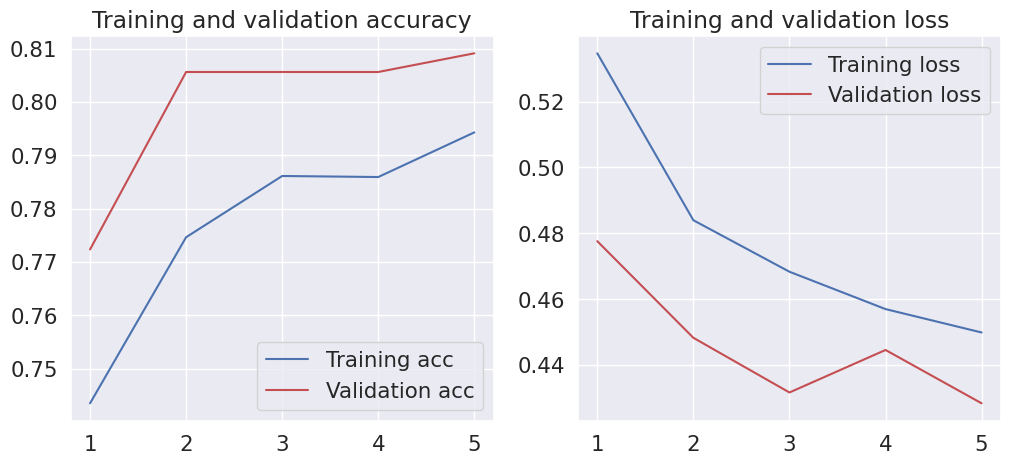

In [380]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NUM_WORDS = 50000

# Matriz de salida
EMBEDDING_DIM = 100

VALIDATION_SPLIT = 0.1


X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)
vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

#https://nlp.stanford.edu/projects/glove/
EMBEDDING_FILE = 'data/glove.6B.100d.txt'
#EMBEDDING_FILE = 'data/glove.twitter.27B.100d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

# Matriz de pesos
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    if index > MAX_NUM_WORDS - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 5

batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


### Palabras que no se encuentran en el diccionario a analizar.

In [279]:
a, b, c = porcentaje_cobertura(train_df['text_clean'],embeddings_index)
print('Pct palabras cubiertas:', b)
print('Pct texto cubierto:', c)
#print('Palabras no cubiertas:', a)
serie = pd.Series(a, index=a.keys())
palabras_df = serie.to_frame().reset_index()
#palabras_df.sort_values(by=0, ascending=False).to_csv('data/palabras_no_tw.csv')




Pct palabras cubiertas: 0.8153997378768021
Pct texto cubierto: 0.9661363127657987


# LSTM

Tokens únicos:  14530
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 46, 100)           1453000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 46, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 1,495,370
Trainable params: 1,495,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
161/161 [==============================] - 20s 125ms/step - loss: 0.5985 - accuracy: 0.6740 - val_loss: 0.5358 - val_accuracy: 0.7338
Epoch 2/2
60/60 [==============================] - 1s 9ms/step - loss: 

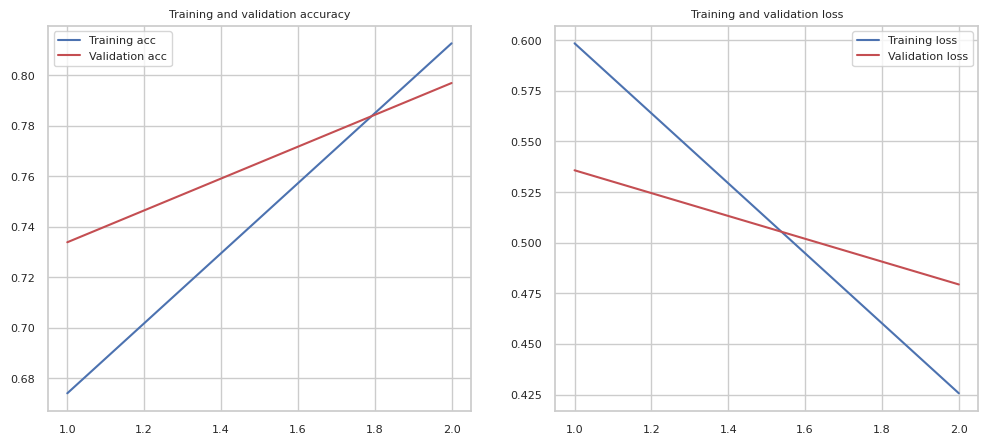

In [19]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NUM_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100

X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)

vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values


# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)


model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


print(model.summary())


epochs = 2

batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# RED CONVOLUCIONAL 1D

Tokens únicos:  15261
Epoch 1/2
81/81 [==============================] - 5s 59ms/step - loss: 0.5409 - accuracy: 0.7392 - val_loss: 0.4718 - val_accuracy: 0.7811
Epoch 2/2
60/60 [==============================] - 0s 7ms/step - loss: 0.4592 - accuracy: 0.7878
Test set
  Loss: 0.459
  Accuracy: 0.788
Training Accuracy: 0.8595
Testing Accuracy:  0.7878


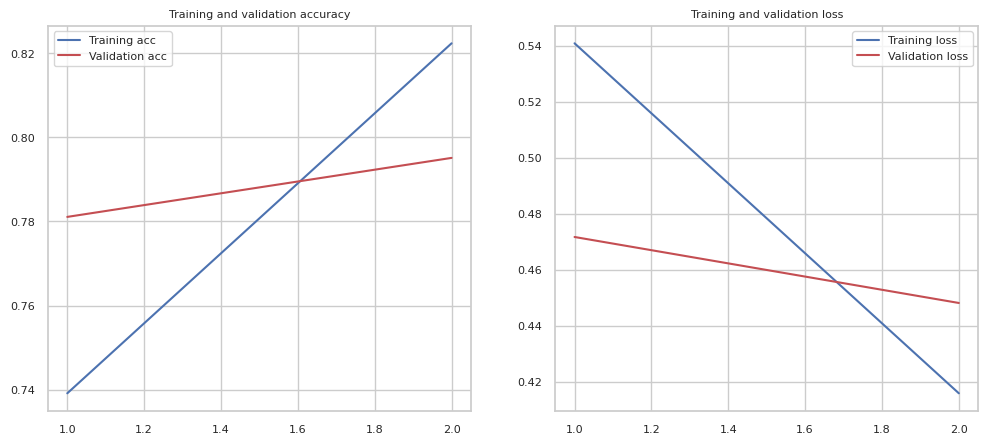

In [312]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NUM_WORDS = 50000

# Matriz de salida
EMBEDDING_DIM = 100

VALIDATION_SPLIT = 0.1


X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)
vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

#https://nlp.stanford.edu/projects/glove/
EMBEDDING_FILE = 'data/glove.6B.100d.txt'
#EMBEDDING_FILE = 'data/glove.twitter.27B.100d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

# Matriz de pesos
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    if index > MAX_NUM_WORDS - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

# Agrego unua red convolucional 1D
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(512, 32, activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


epochs = 2
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# B. MLP Classifier

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      1067
           1       0.72      0.68      0.70       837

    accuracy                           0.74      1904
   macro avg       0.74      0.74      0.74      1904
weighted avg       0.74      0.74      0.74      1904

Matriz de confusión: 
 [[847 220]
 [268 569]]
ROC: 
 0.7368116370444272


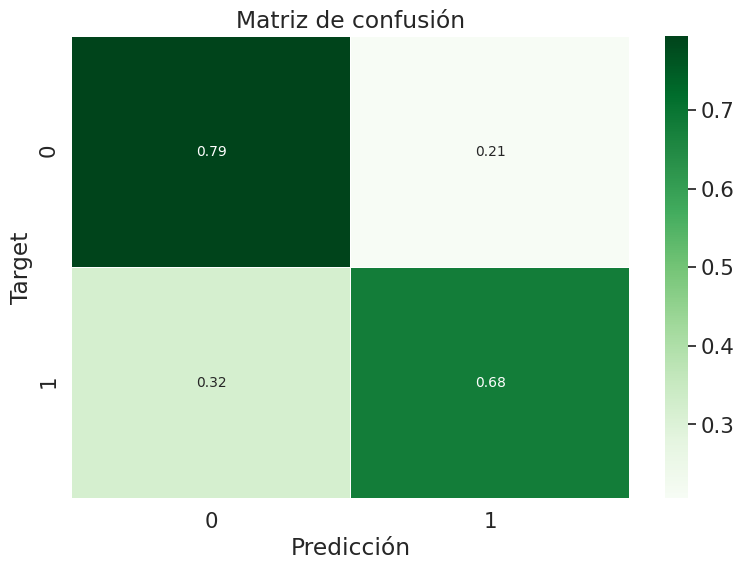

In [41]:
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

MLP = MLPClassifier(activation='relu', solver='adam',random_state=1)

MLP.fit(X_train, y_train)

#Predicciones
y_pred = MLP.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)



# C. Light GBM Classifier

Accu: 0.773 (0.014521)
Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1107
           1       0.79      0.67      0.73       797

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.79      1904

Matriz de confusión: 
 [[968 139]
 [260 537]]
ROC: 
 0.7741060367525465


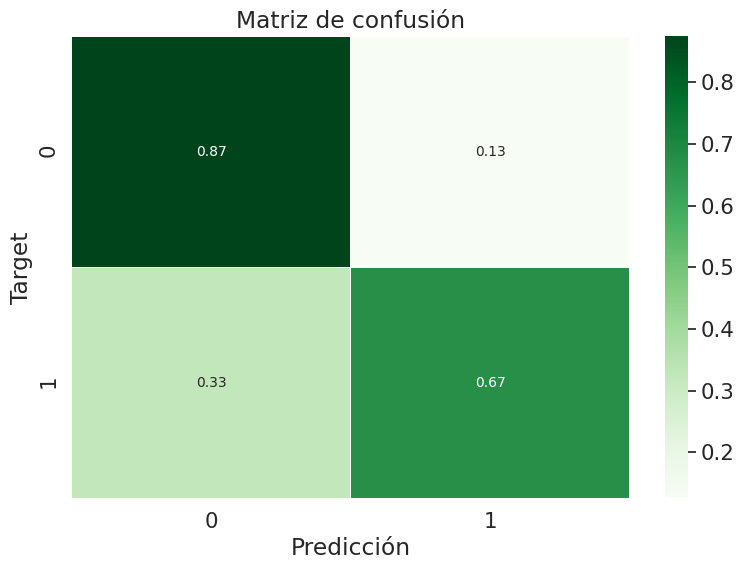

In [762]:
from lightgbm import LGBMClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


LGBM = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBM, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accu: %.3f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))

#Fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

#Predicciones
y_pred = LGBM.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)


# 2. XGBoost - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78      1107
           1       0.75      0.44      0.56       797

    accuracy                           0.71      1904
   macro avg       0.72      0.67      0.67      1904
weighted avg       0.72      0.71      0.69      1904

Matriz de confusión: 
 [[991 116]
 [443 354]]
ROC: 
 0.6696889532676171


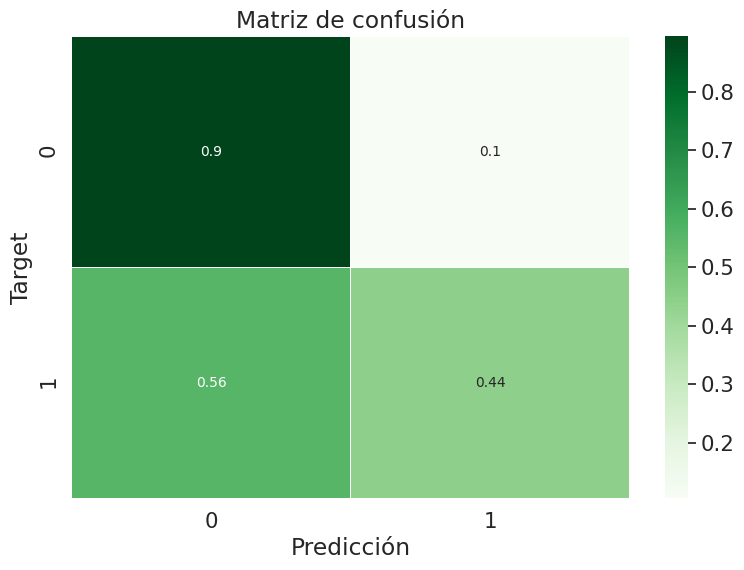

In [749]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1405
           1       0.84      0.61      0.70      1108

    accuracy                           0.78      2513
   macro avg       0.79      0.76      0.76      2513
weighted avg       0.79      0.78      0.77      2513

Matriz de confusión: 
 [[1277  128]
 [ 436  672]]
ROC: 
 0.7576974960494366


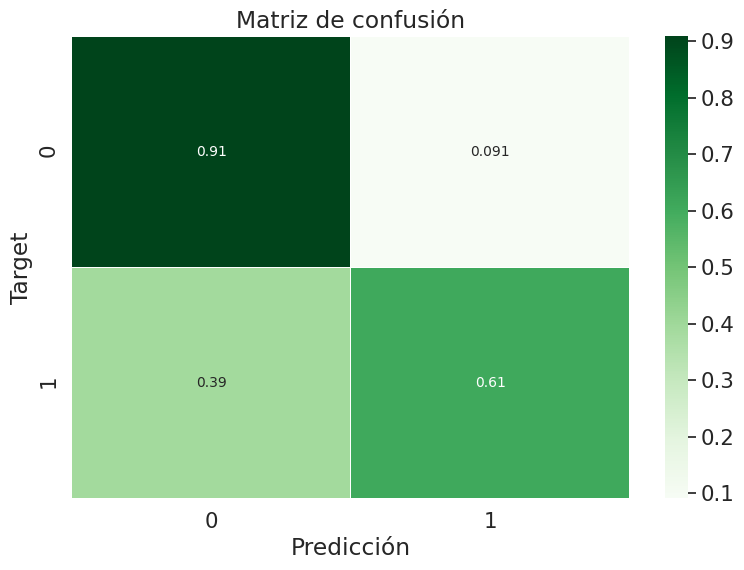

In [42]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators=500, max_depth=131, class_weight = 'balanced',
                             criterion='entropy', max_features='auto', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

#Features importances
#features = np.array(X.columns)
importances = RFC.feature_importances_

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''
print('')

# 4. Regresión Logística - TEXT

In [376]:
from sklearn.model_selection import cross_val_score

X_train = train_df['text_clean']
y_train = train_df['target']

X_test = test_df['text_clean']


# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento

LR = LogisticRegression(C=2, n_jobs=-1)
LR.fit(X_train, y_train)


#Métricas
y_pred = LR.predict(X_test)

# Secuencia [0, 1]
#pred = np.argmax(pred, axis=1)
resultados(y_pred, test_df)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

Weight?,Feature
+4.826,hiroshima
+4.388,fires
+4.171,in
+3.869,california
+3.440,wildfire
+3.436,train
+3.357,bombing
+3.260,fire
+3.249,earthquake
+3.150,storm


# 5. KNN - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1091
           1       0.78      0.62      0.69       813

    accuracy                           0.77      1904
   macro avg       0.77      0.75      0.75      1904
weighted avg       0.77      0.77      0.76      1904

Matriz de confusión: 
 [[950 141]
 [306 507]]
ROC: 
 0.7471885030491001


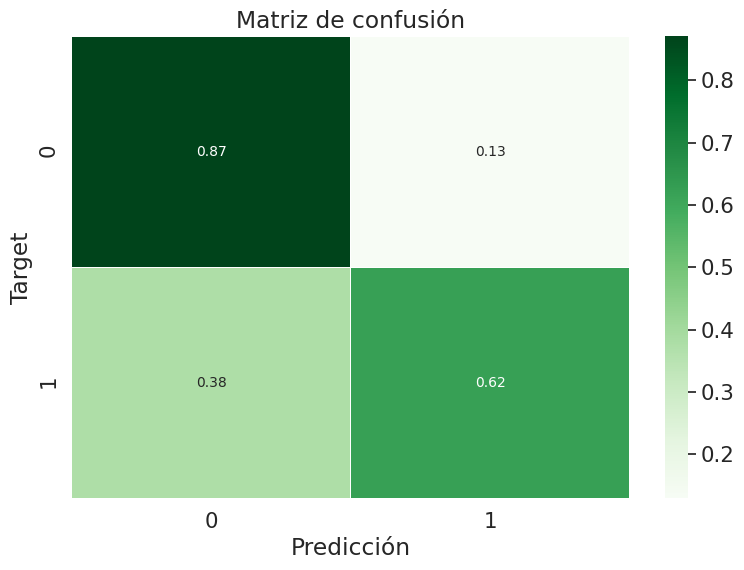

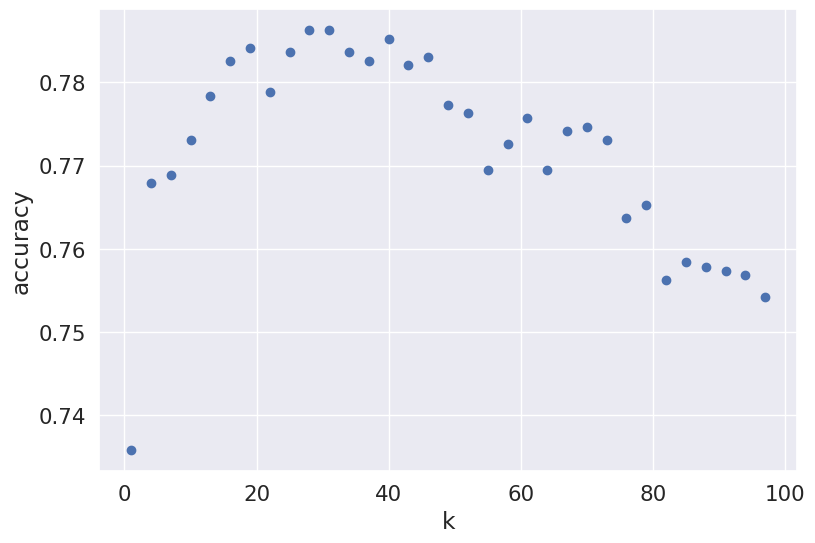

In [1358]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 79, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)


#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()



# 6. Multinomial NB - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1107
           1       0.86      0.62      0.72       797

    accuracy                           0.80      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.81      0.80      0.79      1904

Matriz de confusión: 
 [[1024   83]
 [ 302  495]]
ROC: 
 0.7730508149916295


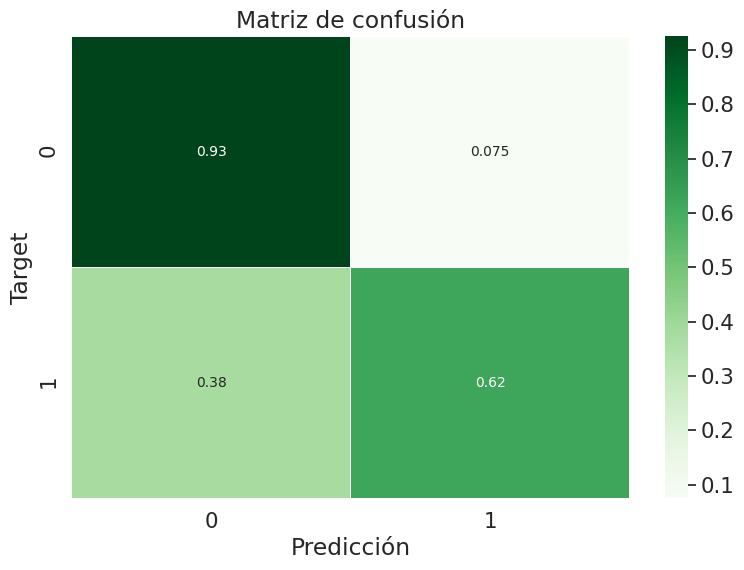

In [673]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)